# Задача
В этой работе вам предлагается решить задачу регрессии, а именно построить алгоритм, определяющий качество вина на основе физико-химических тестов:
 - fixed acidity
 - volatile acidity
 - citric acid
 - residual sugar
 - chlorides
 - free sulfur dioxide
 - total sulfur dioxide
 - density
 - pH
 - sulphates
 - alcohol 
 
Более подробно про признаки можно почитать [здесь](https://archive.ics.uci.edu/ml/datasets/wine+quality). Целевой признак записан в переменной *quality*.

В этой задаче для обучения будут использовать 2 алгоритма:
- [DecisonTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
- [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)

# Решение

Загрузите набор данных *winequality-red.csv* с помощью `pandas` (скачать можно [здесь](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv), или с помощью скрипта ниже). Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [1]:
# !wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
# your code here
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

df = pd.read_csv('winequality-red.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## Анализ и предобработка данных

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 
1. Проверьте есть ли в данных пропущенные значения. Удалите из выборки все объекты с пропусками и дубликаты.
2. Выделите 70% выборки для обучения и дальнейшего анализа.
3. Проанализируйте признаки и по необходимости предобработайте их. Все шаги предобработки поясните текстом.
4. Целевую переменную (ту, которую мы хотим предсказывать) можно выделить в отдельную переменную (НЕ забудьте удалить ее из датасета, когда будете обучать модель).

In [4]:
# your code here
print(f'Размер данных до удаления пропусков и дубликатов: {df.shape}')

# Проверка на пропущенные значения и дубликаты
print(f'Пропущенные значения:\n {df.isnull().sum()}')
print(f'Дубликаты:\n {df.duplicated().sum()}')

# При проверке выяснили, что пропущенных значений нет, но есть дубликаты. Удаляем дубликаты
df = df.drop_duplicates()

print(f'Размер данных после удаления пропусков и дубликатов: {df.shape}')

Размер данных до удаления пропусков и дубликатов: (1599, 12)
Пропущенные значения:
 fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Дубликаты:
 240
Размер данных после удаления пропусков и дубликатов: (1359, 12)


In [6]:
train_data, test_data = train_test_split(df, test_size=0.3, random_state=42)

print(f'Размер обучающей выборки: {train_data.shape}')
print(f'Размер тестовой выборки: {test_data.shape}')

Размер обучающей выборки: (951, 12)
Размер тестовой выборки: (408, 12)


In [8]:
# Посмотрим на основные статистические характеристики данных:
print(train_data.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count     951.000000        951.000000   951.000000      951.000000   
mean        8.307992          0.528517     0.272702        2.486751   
std         1.717348          0.176957     0.195434        1.210386   
min         4.600000          0.160000     0.000000        0.900000   
25%         7.100000          0.400000     0.100000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.100000          0.637500     0.420000        2.600000   
max        15.900000          1.580000     0.780000       13.900000   

        chlorides  free sulfur dioxide  total sulfur dioxide     density  \
count  951.000000           951.000000            951.000000  951.000000   
mean     0.088570            15.694006             46.842271    0.996700   
std      0.049604            10.272675             33.603639    0.001818   
min      0.012000             2.000000              6.00

In [10]:
# Выделение признаков и целевой переменной
X_train = train_data.drop('quality', axis=1)
y_train = train_data['quality']

X_test = test_data.drop('quality', axis=1)
y_test = test_data['quality']

# Стандартизируем данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Обучение модели регрессии

Постройте модель регрессии, используя 2 алгоритма:
- [DecisonTree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
- [AdaBoostRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html#sklearn.ensemble.AdaBoostRegressor)

Для начала используйте гиперпараметры по умолчанию.

Рассчитайте среднее качество кросс-валидации модели как долю дисперсии зависимой переменной (коэффициент детерминации) $R^2$. Каким получилось качество? Какой алгоритм вы бы выбрали для дальнейшей работы? Обоснуйте свой выбор.

In [13]:
# your code here
dt_regressor = DecisionTreeRegressor(random_state=42)
ada_regressor = AdaBoostRegressor(random_state=42)

dt_scores = cross_val_score(dt_regressor, X_train_scaled, y_train, cv=5, scoring='r2')
dt_mean_r2 = dt_scores.mean()

ada_scores = cross_val_score(ada_regressor, X_train_scaled, y_train, cv=5, scoring='r2')
ada_mean_r2 = ada_scores.mean()

print(f'Средний R^2 для DecisionTreeRegressor: {dt_mean_r2:.2f}')
print(f'Средний R^2 для AdaBoostRegressor: {ada_mean_r2:.2f}')

# На основе полученных результатов, AdaBoostRegressor показывает более высокий коэффициент детерминации по сравнению с DecisionTreeRegressor, 
# что указывает на лучшее объяснение дисперсии целевой переменной.
# Также, AdaBoostRegressor, как ансамблевый метод, менее склонен к переобучению по сравнению с DecisionTreeRegressor.
# Поэтому для дальнейшей работы я бы выбрал AdaBoostRegressor.

Средний R^2 для DecisionTreeRegressor: -0.22
Средний R^2 для AdaBoostRegressor: 0.33


Теперь сделаем подбор оптимальных гиперпараметров. Сделайте поиск по сетке с помощью кросс-валидации. Изменилось ли качество алгоритмов? Почему?

In [20]:
# your code here
# Сетка гиперпараметров для DecisionTreeRegressor
dt_param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10]
}

# Сетка гиперпараметров для AdaBoostRegressor
ada_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 1.0]
}

# Для DecisionTreeRegressor
dt_grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=dt_param_grid,
    scoring='r2',
    cv=5,
)

# Для AdaBoostRegressor
ada_grid_search = GridSearchCV(
    estimator=AdaBoostRegressor(random_state=42),
    param_grid=ada_param_grid,
    scoring='r2',
    cv=5,
)

dt_grid_search.fit(X_train_scaled, y_train)
ada_grid_search.fit(X_train_scaled, y_train)

print(f'Лучшие параметры для DecisionTreeRegressor: {dt_grid_search.best_params_}')
print(f'Лучший R^2 для DecisionTreeRegressor: {dt_grid_search.best_score_:.2f}')

print(f'Лучшие параметры для AdaBoostRegressor: {ada_grid_search.best_params_}')
print(f'Лучший R^2 для AdaBoostRegressor: {ada_grid_search.best_score_:.2f}')

# DecisionTreeRegressor:
# Качество значительно улучшилось, так как ограничение глубины дерева (max_depth) и других параметров предотвратило переобучение модели.

# AdaBoostRegressor:
# Качество не изменилось. AdaBoostRegressor уже изначально показал хорошие результаты.

Лучшие параметры для DecisionTreeRegressor: {'max_depth': 3, 'min_samples_split': 2}
Лучший R^2 для DecisionTreeRegressor: 0.27
Лучшие параметры для AdaBoostRegressor: {'learning_rate': 0.1, 'n_estimators': 200}
Лучший R^2 для AdaBoostRegressor: 0.33


Оцените скорость обучения каждого из алгоритмов. Для этого воспользуйтесь графиком вида "ящик с усами", который отражает среднее время обучения алгоритма при фиксированном значении гиперпараметров. Что вы можете сказать о скорости работы алгоритмов? Почему наблюдаются такие результаты? Можно ли ускорить? Если да, то каким образом?

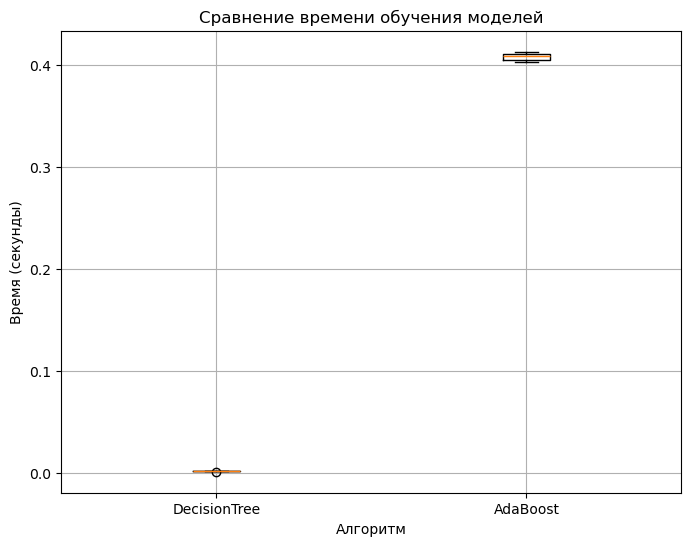

In [23]:
# your code here
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Фиксированные лучшие ранее подобранные гиперпараметры
dt_params = {'max_depth': 3, 'min_samples_split': 2}
ada_params = {'n_estimators': 200, 'learning_rate': 0.1}

n_iterations = 10
dt_times = []
ada_times = []

for _ in range(n_iterations):
    start_time = time.time()
    dt_model = DecisionTreeRegressor(**dt_params, random_state=42)
    dt_model.fit(X_train_scaled, y_train)
    dt_times.append(time.time() - start_time)

    start_time = time.time()
    ada_model = AdaBoostRegressor(**ada_params, random_state=42)
    ada_model.fit(X_train_scaled, y_train)
    ada_times.append(time.time() - start_time)

data = [dt_times, ada_times]

plt.figure(figsize=(8, 6))
plt.boxplot(data, labels=['DecisionTree', 'AdaBoost'])
plt.title('Сравнение времени обучения моделей')
plt.ylabel('Время (секунды)')
plt.xlabel('Алгоритм')
plt.grid(True)
plt.show()

# Анализируя график, можно сделать следующие выводы:
# - DecisionTreeRegressor работает быстрее, так как строит одно дерево.
# - AdaBoostRegressor работает медленнее, так как строит ансамбль из множества деревьев.
# - Скорость можно улучшить, настраивая гиперпараметры или используя более эффективные реализации алгоритмов. 
# Для DecisionTreeRegressor можно у меньшить глубину дерева (max_depth), увеличить min_samples_split или min_samples_leaf, 
# чтобы уменьшить количество узлов в дереве.
# Для AdaBoostRegressor можно уменьшить количество деревьев (n_estimators), увеличить learning_rate, чтобы уменьшить количество итераций, 
# необходимых для сходимости.

## PCA преобразование

Теперь попробуем сделать преобразрование данных с помощью PCA. Выберите оптимальное количество компонент и преобразуйте данные. Объясните свой выбор.

In [26]:
# your code here
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

# Вычисление кумулятивной объясненной дисперсии
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
n_components = np.argmax(cumulative_explained_variance >= 0.9) + 1
print(f"Оптимальное количество компонент: {n_components}")

# Применим PCA с выбранным количеством компонент
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Размерность данных после PCA: {X_train_pca.shape}")

# Данное количество компонент было выбрано как оптимальное, так как увеличение порога выше 0.9 не будет улушать результаты и увеличит время обучения.

Оптимальное количество компонент: 7
Размерность данных после PCA: (951, 7)


## Обучение моделей на данных, трансформированных с помощью PCA

Обучим те же классификаторы на трансформированных с помощью PCA данных. Подберите оптимальные значения исследуемых гиперпараметров для новых данных. Какой алгоритм справился лучше? Какой быстрее? Почему?

In [29]:
# your code here
dt_pca_grid_search = GridSearchCV(
    estimator=DecisionTreeRegressor(random_state=42),
    param_grid=dt_param_grid,
    scoring='r2',
    cv=5,
)

ada_pca_grid_search = GridSearchCV(
    estimator=AdaBoostRegressor(random_state=42),
    param_grid=ada_param_grid,
    scoring='r2',
    cv=5,
)

start_time = time.time()
dt_grid_search.fit(X_train_pca, y_train)
dt_time = time.time() - start_time

start_time = time.time()
ada_grid_search.fit(X_train_pca, y_train)
ada_time = time.time() - start_time

print(f'Лучшие параметры для DecisionTreeRegressor (PCA): {dt_grid_search.best_params_}')
print(f'Лучший R^2 для DecisionTreeRegressor (PCA): {dt_grid_search.best_score_:.2f}')
print(f'Время обучения DecisionTreeRegressor (PCA): {dt_time:.2f}')

# Лучшие параметры и качество для AdaBoostRegressor
print(f'Лучшие параметры для AdaBoostRegressor (PCA): {ada_grid_search.best_params_}')
print(f'Лучший R^2 для AdaBoostRegressor (PCA): {ada_grid_search.best_score_:.2f}')
print(f'Время обучения AdaBoostRegressor (PCA): {ada_time:.2f}')

# AdaBoostRegressor работает лучше, так как это ансамблевый метод, который комбинирует множество деревьев для улучшения предсказаний, в то время как
# DecisionTreeRegressor проигрывает в качестве, так как это одна модель, которая может переобучиться или не уловить сложные зависимости в данных.
# Как и ранее DecisionTreeRegressor работает быстрее чем AdaBoostRegressor, так как строит одно дерево.

Лучшие параметры для DecisionTreeRegressor (PCA): {'max_depth': 3, 'min_samples_split': 2}
Лучший R^2 для DecisionTreeRegressor (PCA): 0.21
Время обучения DecisionTreeRegressor (PCA): 0.25
Лучшие параметры для AdaBoostRegressor (PCA): {'learning_rate': 1.0, 'n_estimators': 50}
Лучший R^2 для AdaBoostRegressor (PCA): 0.30
Время обучения AdaBoostRegressor (PCA): 12.53


## Сравнение результатов

Сравните результаты полученные до трансформации данных с помощью PCA и после. Для этого воспользуйтесь "ящиком с усами" (boxplot).

Сделайте общие итоговые выводы о моделях регрессии с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

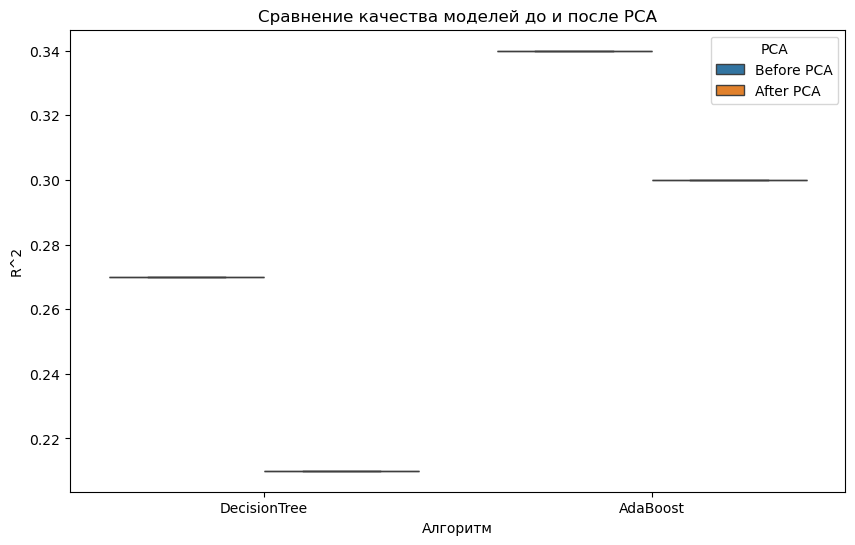

In [32]:
# your code here
# Результаты до PCA
dt_r2_before_pca = 0.27
ada_r2_before_pca = 0.34

# Результаты после PCA
dt_r2_after_pca = 0.21
ada_r2_after_pca = 0.30

results = [dt_r2_before_pca, dt_r2_after_pca, ada_r2_before_pca, ada_r2_after_pca]

results_df = pd.DataFrame({
    'Algorithm': ['DecisionTree'] * 2 + ['AdaBoost'] * 2,
    'PCA': ['Before PCA'] + ['After PCA'] + ['Before PCA'] + ['After PCA'],
    'R2': results
})

plt.figure(figsize=(10, 6))
sns.boxplot(x='Algorithm', y='R2', hue='PCA', data=results_df)
plt.title('Сравнение качества моделей до и после PCA')
plt.ylabel('R^2')
plt.xlabel('Алгоритм')
plt.legend(title='PCA')
plt.show()

# Общие итоговые выводы:
# - AdaBoostRegressor в сравнении с DecisionTreeRegressor показал лучшее качество как до, так и после PCA. Это связано с тем, 
# что ансамблевые методы обычно лучше обобщают данные.
# - DecisionTreeRegressor работает быстрее, так как строит одно дерево.
# - В нашем случае применение PCA немного ухудшило качество обеих моделей,.
# - Изменение гиперпараметров моделей сильно влияет на их качество. Например, увеличение max_depth в DecisionTreeRegressor может привести к переобучению.
# - Если важнее качество, лучше выбрать AdaBoostRegressor, если скорость, то DecisionTreeRegressor.

## Тестирование всех модели

Протестируйте все построенные модели (в т.ч. с и без PCA трансформации) на данных, которые были отложены для теста (их должно было остаться 30%). Не забудьте про все необходимые преобразования.

In [34]:
# your code here
from sklearn.metrics import r2_score

X_test_pca = pca.transform(X_test_scaled)

# Модели без PCA
dt_model_before_pca = DecisionTreeRegressor(max_depth=3, min_samples_split=2, random_state=42)
dt_model_before_pca.fit(X_train_scaled, y_train)
dt_pred_before_pca = dt_model_before_pca.predict(X_test_scaled)
dt_r2_before_pca = r2_score(y_test, dt_pred_before_pca)

ada_model_before_pca = AdaBoostRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
ada_model_before_pca.fit(X_train_scaled, y_train)
ada_pred_before_pca = ada_model_before_pca.predict(X_test_scaled)
ada_r2_before_pca = r2_score(y_test, ada_pred_before_pca)

# Модели с PCA
dt_model_after_pca = DecisionTreeRegressor(max_depth=3, min_samples_split=2, random_state=42)
dt_model_after_pca.fit(X_train_pca, y_train)
dt_pred_after_pca = dt_model_after_pca.predict(X_test_pca)
dt_r2_after_pca = r2_score(y_test, dt_pred_after_pca)

ada_model_after_pca = AdaBoostRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
ada_model_after_pca.fit(X_train_pca, y_train)
ada_pred_after_pca = ada_model_after_pca.predict(X_test_pca)
ada_r2_after_pca = r2_score(y_test, ada_pred_after_pca)

print(f'Результаты на тестовых данных:')
print(f'DecisionTreeRegressor (без PCA): R^2 = {dt_r2_before_pca:.2f}')
print(f'AdaBoostRegressor (без PCA): R^2 = {ada_r2_before_pca:.2f}')
print(f'DecisionTreeRegressor (с PCA): R^2 = {dt_r2_after_pca:.2f}')
print(f'AdaBoostRegressor (с PCA): R^2 = {ada_r2_after_pca:.2f}')

Результаты на тестовых данных:
DecisionTreeRegressor (без PCA): R^2 = 0.28
AdaBoostRegressor (без PCA): R^2 = 0.45
DecisionTreeRegressor (с PCA): R^2 = 0.27
AdaBoostRegressor (с PCA): R^2 = 0.35


In [ ]:
# По результатам тестирования моделей можно сделать вывод, что на тестовых данных модели показывают несколько
# более высокие результаты. В то же время сохранилась тенденция, что при добавлении PCA результаты обеих
# моделей снизились.